# PTB-XL Extended EDA and Modeling-Oriented Analysis

This notebook provides a comprehensive, model-driven exploratory analysis of the PTB-XL dataset. It extends a basic EDA with checks and insights that inform downstream modeling decisions such as task selection, preprocessing, loss functions, and evaluation protocols.

Outline:
- 0) Environment, configuration, and imports
- 1) Load metadata and build label taxonomies (diagnostic, rhythm, form)
- 2) Dataset overview: records, patients, demographics, official splits
- 3) Label distributions, multi-label metrics, conditional co-occurrence
- 4) Patient-level leakage and duplicates
- 5) Domain shift by device/site (plus PCA of simple features)
- 6) Leads and sampling frequency comparison (100 Hz vs 500 Hz)
- 7) Signal quality control (amplitude, noise proxies) and duration
- 8) Waveform gallery samples per label
- 9) Practical recommendations for modeling directions

Notes:
- Designed to run even if `wfdb` is missing (waveform sections will gracefully skip).
- Uses plain Matplotlib to maximize portability.
- Adjust `DATA_ROOT` paths as needed for your environment.



## 0) Environment, configuration, and imports

Why this matters:
- Reproducible configuration and graceful degradation if optional deps are missing.
- Centralized paths and constants make the notebook easy to adapt across machines.



In [1]:
import os
import ast
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import wfdb
except Exception:
    wfdb = None
    warnings.warn("wfdb not installed; waveform sections will be skipped.")

# Matplotlib style fallback for broad compatibility
for style_name in ['seaborn-v0_8-whitegrid', 'seaborn-whitegrid', 'seaborn']:
    try:
        plt.style.use(style_name)
        break
    except Exception:
        continue

# Configuration
DATA_ROOT = os.path.abspath("data/ptb-xl/")
DB_CSV = os.path.join(DATA_ROOT, "ptbxl_database.csv")
SCP_CSV = os.path.join(DATA_ROOT, "scp_statements.csv")

# Safety checks
assert os.path.exists(DB_CSV), f"Missing {DB_CSV}"
assert os.path.exists(SCP_CSV), f"Missing {SCP_CSV}"
print("Using DATA_ROOT:", DATA_ROOT)


Using DATA_ROOT: /mnt/hdd1/yasser/code/ecg/data/ptb-xl


## 1) Load metadata and build label taxonomies (diagnostic, rhythm, form)

Why this matters:
- Understanding PTB-XL labels requires mapping SCP codes to higher-level categories.
- We extract diagnostic superclasses and also parse rhythm and form to enable multi-task analyses.



In [2]:
# Load CSVs
ptbxl_df = pd.read_csv(DB_CSV)
scp_df = pd.read_csv(SCP_CSV, index_col=0)

# Parse SCP code dicts per record
ptbxl_df['scp_codes_dict'] = ptbxl_df['scp_codes'].apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else {})

# Diagnostic taxonomy
scp_diag = scp_df[scp_df['diagnostic'] == 1]
label_map_diag = scp_diag['diagnostic_class'].to_dict()  # SCP code -> superclass

ptbxl_df['diagnostic_superclass'] = ptbxl_df['scp_codes_dict'].apply(
    lambda d: sorted({label_map_diag[c] for c in d.keys() if c in label_map_diag})
)

# Rhythm and form groups
scp_rhythm = scp_df[scp_df['rhythm'] == 1].index.tolist()
scp_form = scp_df[scp_df['form'] == 1].index.tolist()

def extract_group(code_keys, allowed_codes):
    return sorted([c for c in code_keys if c in allowed_codes])

ptbxl_df['labels_rhythm'] = ptbxl_df['scp_codes_dict'].apply(lambda d: extract_group(d.keys(), scp_rhythm))
ptbxl_df['labels_form'] = ptbxl_df['scp_codes_dict'].apply(lambda d: extract_group(d.keys(), scp_form))

# Primary SCP for quick summaries (highest confidence)
ptbxl_df['primary_scp'] = ptbxl_df['scp_codes_dict'].apply(
    lambda d: max(d.items(), key=lambda kv: kv[1])[0] if d else None
)

# Superclass universe
superclasses = sorted({c for classes in ptbxl_df['diagnostic_superclass'] for c in classes})
print('Superclasses:', superclasses)
print('Example rows:')
display(ptbxl_df.head(3)[['ecg_id','patient_id','diagnostic_superclass','labels_rhythm','labels_form','primary_scp']])


Superclasses: ['CD', 'HYP', 'MI', 'NORM', 'STTC']
Example rows:


,ecg_id,patient_id,diagnostic_superclass,labels_rhythm,labels_form,primary_scp
0,1,15709.0,[NORM],[SR],[LVOLT],NORM
1,2,13243.0,[NORM],[SBRAD],[],NORM
2,3,20372.0,[NORM],[SR],[],NORM


## 2) Dataset overview: records, patients, demographics, official splits

Why this matters:
- Establishes cohort size and composition; confirms stratified folds; detects anomalies in demographics.



Records: 21799
Unique patients: 18869


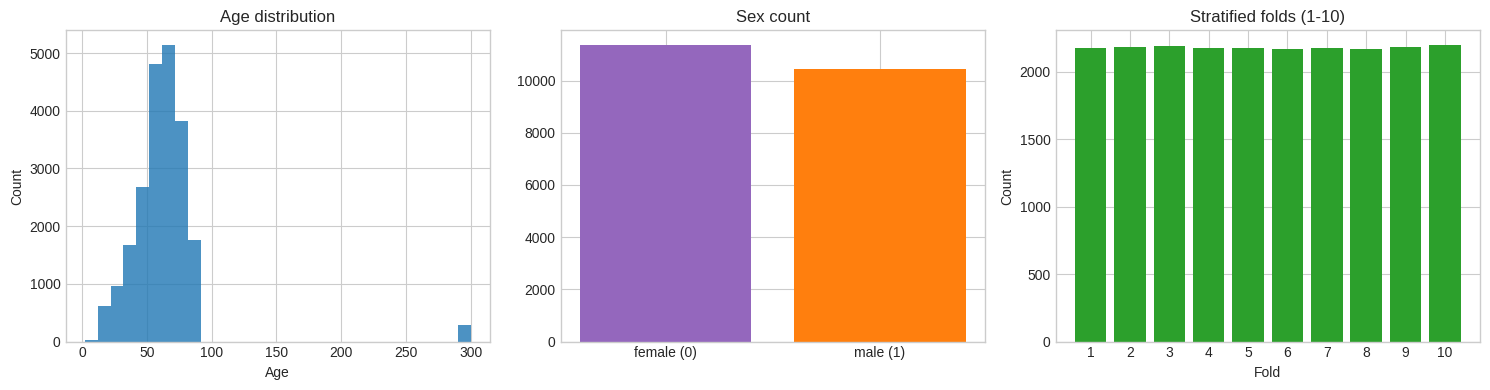

Train size: 19601 Test size: 2198


In [3]:
# Basic counts
n_records = len(ptbxl_df)
n_patients = ptbxl_df['patient_id'].nunique()
print(f"Records: {n_records}")
print(f"Unique patients: {n_patients}")

# Demographics
ptbxl_df['age'] = pd.to_numeric(ptbxl_df['age'], errors='coerce')
ptbxl_df['sex'] = pd.to_numeric(ptbxl_df['sex'], errors='coerce')  # 0=female, 1=male

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(ptbxl_df['age'].dropna(), bins=30, color='tab:blue', alpha=0.8)
axes[0].set_title('Age distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

sex_counts = ptbxl_df['sex'].value_counts().sort_index()
axes[1].bar(['female (0)','male (1)'], sex_counts.values, color=['tab:purple','tab:orange'])
axes[1].set_title('Sex count')

fold_counts = ptbxl_df['strat_fold'].value_counts().sort_index()
axes[2].bar(fold_counts.index.astype(str), fold_counts.values, color='tab:green')
axes[2].set_title('Stratified folds (1-10)')
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('Count')
plt.tight_layout()
plt.show()

# Official split summary (fold 10 as test)
TEST_FOLD = 10
train_mask = ptbxl_df['strat_fold'] != TEST_FOLD
test_mask = ptbxl_df['strat_fold'] == TEST_FOLD
print('Train size:', train_mask.sum(), 'Test size:', test_mask.sum())


## 3) Label distributions, multi-label metrics, conditional co-occurrence

Why this matters:
- Imbalance and label co-occurrence drive loss weighting, threshold tuning, and model heads.
- Conditional co-occurrence P(y_i | y_j) reveals hierarchical/structured dependencies.



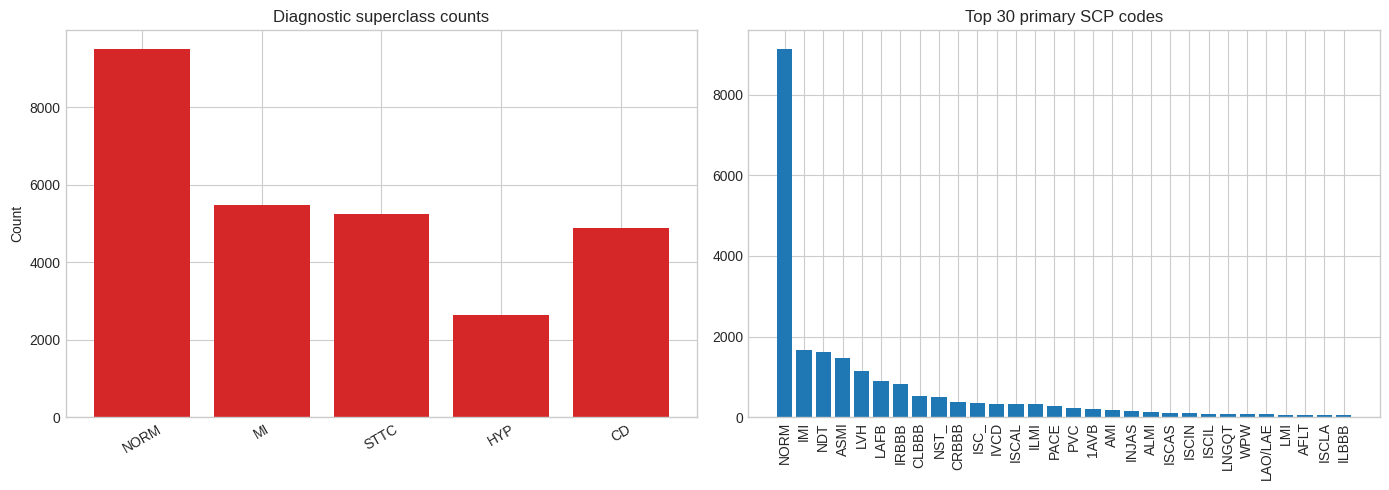

Superclasses: 5
Label cardinality (superclasses): 1.274
Label density (superclasses): 0.255


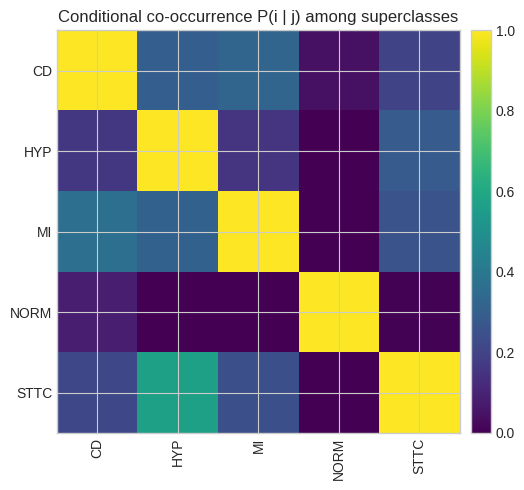

In [4]:
from collections import Counter

# Superclass counts
superclass_counts = Counter([c for classes in ptbxl_df['diagnostic_superclass'] for c in classes])
scp_counts = ptbxl_df['primary_scp'].value_counts().head(30)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(list(superclass_counts.keys()), list(superclass_counts.values()), color='tab:red')
axes[0].set_title('Diagnostic superclass counts')
axes[0].tick_params(axis='x', rotation=30)
axes[0].set_ylabel('Count')

axes[1].bar(scp_counts.index, scp_counts.values, color='tab:blue')
axes[1].set_title('Top 30 primary SCP codes')
axes[1].tick_params(axis='x', rotation=90)
plt.tight_layout(); plt.show()

# Multi-label metrics (superclass)
num_labels_super = len(superclasses)
label_cardinality_super = ptbxl_df['diagnostic_superclass'].apply(len).mean()
label_density_super = label_cardinality_super / max(num_labels_super, 1)
print(f"Superclasses: {num_labels_super}")
print(f"Label cardinality (superclasses): {label_cardinality_super:.3f}")
print(f"Label density (superclasses): {label_density_super:.3f}")

# Conditional co-occurrence among superclasses
super_to_idx = {c: i for i, c in enumerate(superclasses)}
Y_super = np.zeros((len(ptbxl_df), len(superclasses)), dtype=int)
for i, classes in enumerate(ptbxl_df['diagnostic_superclass']):
    for c in classes:
        Y_super[i, super_to_idx[c]] = 1

co_counts = Y_super.T @ Y_super  # co-occurrence counts
marg = Y_super.sum(axis=0).clip(min=1)
cond = co_counts / marg[np.newaxis, :]  # P(i | j): columns condition

fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(cond, cmap='viridis', vmin=0, vmax=1)
ax.set_xticks(range(len(superclasses)))
ax.set_yticks(range(len(superclasses)))
ax.set_xticklabels(superclasses, rotation=90)
ax.set_yticklabels(superclasses)
ax.set_title('Conditional co-occurrence P(i | j) among superclasses')
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.02)
plt.tight_layout(); plt.show()


## 4) Patient-level leakage and duplicates

Why this matters:
- Prevents over-optimistic evaluation by ensuring records from the same patient don’t leak across splits.
- Detects exact/near duplicates (e.g., resampled versions) that can bias metrics.



In [5]:
# Check patient leakage across official fold 10 split
train_patients = set(ptbxl_df.loc[train_mask, 'patient_id'].astype(int).tolist())
test_patients = set(ptbxl_df.loc[test_mask, 'patient_id'].astype(int).tolist())
intersection = train_patients.intersection(test_patients)
print(f"Patients in train: {len(train_patients)}, in test: {len(test_patients)}, overlap: {len(intersection)}")
assert len(intersection) == 0, "Patient leakage detected across train/test!"  # should be zero in PTB-XL

# Duplicate-like records within patients: multiple ECGs same day with same primary SCP
ptbxl_df['recording_date'] = pd.to_datetime(ptbxl_df['recording_date'], errors='coerce')
dup_keys = ptbxl_df.groupby(['patient_id', ptbxl_df['recording_date'].dt.date, 'primary_scp']).size()
possible_dups = dup_keys[dup_keys > 1].sort_values(ascending=False)
print("Potential within-patient duplicate clusters (same day & primary_scp):", len(possible_dups))
if len(possible_dups) > 0:
    display(possible_dups.head(10))


Patients in train: 16965, in test: 1904, overlap: 0
Potential within-patient duplicate clusters (same day & primary_scp): 80


patient_id  recording_date  primary_scp
10099.0     2000-07-16      PACE           5
18011.0     1994-01-11      NORM           4
10134.0     1995-11-17      ASMI           4
10222.0     1997-07-10      NORM           4
19348.0     1995-08-15      IMI            4
13496.0     1993-01-24      NORM           3
18616.0     1999-01-14      ILMI           3
18343.0     1999-01-28      NDT            3
20105.0     1990-11-11      ISCAL          3
18675.0     2000-01-08      ISCAL          3
dtype: int64

## 5) Domain shift by device/site (plus PCA of simple features)

Why this matters:
- Device and site can induce covariate shift; understanding it guides stratification and adaptation.



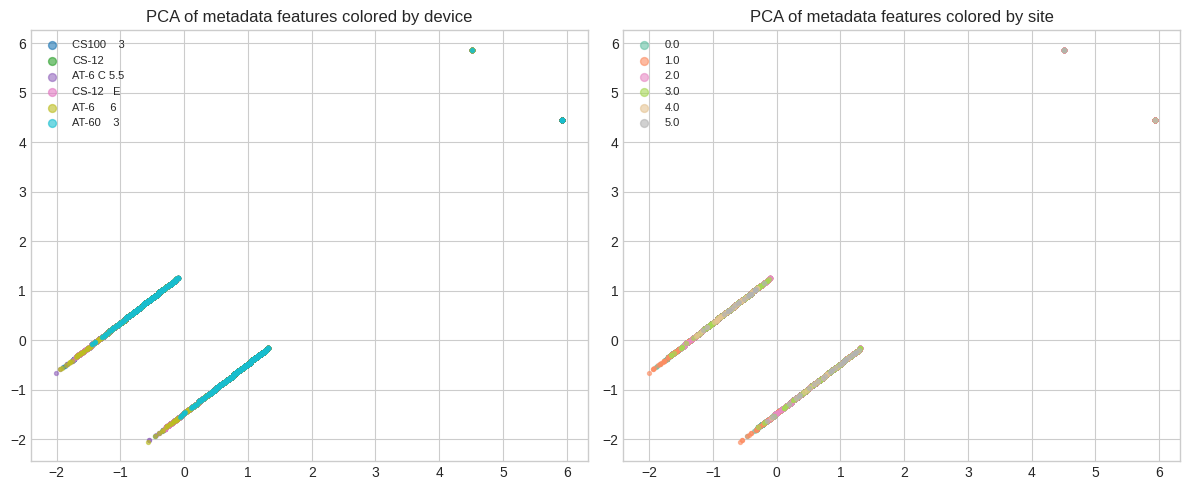

Superclass prevalence by top devices:
      CS100    3     CS-12  AT-6 C 5.5  CS-12   E  AT-6     6  AT-60    3
CD      0.234365  0.276186    0.225823   0.114663    0.226133    0.218427
HYP     0.154723  0.092638    0.157215   0.024322    0.136384    0.073499
MI      0.359121  0.262352    0.198734   0.071925    0.221733    0.311594
NORM    0.288436  0.408844    0.476456   0.783530    0.439067    0.418219
STTC    0.273290  0.235425    0.266835   0.063238    0.286846    0.229814

Superclass prevalence by top sites:
           0.0       1.0       2.0       3.0   4.0       5.0
CD    0.196309  0.225135  0.265025  0.274306  0.28  0.275862
HYP   0.113199  0.151096  0.089064  0.166667  0.21  0.155172
MI    0.267338  0.206546  0.272315  0.345486  0.28  0.241379
NORM  0.446421  0.457896  0.410246  0.260417  0.36  0.344828
STTC  0.205705  0.278837  0.235074  0.338542  0.34  0.344828


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Simple engineered features from metadata (no waveform read): age, sex, noise flags
num_cols = ['age']
bin_cols = ['sex','baseline_drift','static_noise','burst_noise','electrodes_problems']
for c in num_cols + bin_cols:
    if c in ptbxl_df.columns:
        ptbxl_df[c] = pd.to_numeric(ptbxl_df[c], errors='coerce')

feature_cols = [c for c in num_cols + bin_cols if c in ptbxl_df.columns]
X = ptbxl_df[feature_cols].fillna(0.0).to_numpy()
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Color by device (top devices only)
top_devices = ptbxl_df['device'].value_counts().head(6).index.tolist()
colors = plt.cm.tab10(np.linspace(0, 1, len(top_devices)))
for col, dev in zip(colors, top_devices):
    mask = ptbxl_df['device'] == dev
    axes[0].scatter(Z[mask, 0], Z[mask, 1], s=8, alpha=0.6, color=col, label=str(dev))
axes[0].set_title('PCA of metadata features colored by device')
axes[0].legend(markerscale=2, fontsize=8, frameon=False)

# Color by site (top sites only)
top_sites = ptbxl_df['site'].value_counts().head(6).index.tolist()
colors = plt.cm.Set2(np.linspace(0, 1, len(top_sites)))
for col, site in zip(colors, top_sites):
    mask = ptbxl_df['site'] == site
    axes[1].scatter(Z[mask, 0], Z[mask, 1], s=8, alpha=0.6, color=col, label=str(site))
axes[1].set_title('PCA of metadata features colored by site')
axes[1].legend(markerscale=2, fontsize=8, frameon=False)

plt.tight_layout(); plt.show()

# Tabular prevalence by device/site for superclasses
from collections import Counter

super_to_idx = {c: i for i, c in enumerate(superclasses)}
Y_super = np.zeros((len(ptbxl_df), len(superclasses)), dtype=int)
for i, classes in enumerate(ptbxl_df['diagnostic_superclass']):
    for c in classes:
        Y_super[i, super_to_idx[c]] = 1

# Prevalence per device for top devices
device_tables = {}
for dev in top_devices:
    m = Y_super[ptbxl_df['device'] == dev].mean(axis=0)
    device_tables[dev] = m

site_tables = {}
for site in top_sites:
    m = Y_super[ptbxl_df['site'] == site].mean(axis=0)
    site_tables[site] = m

print('Superclass prevalence by top devices:')
print(pd.DataFrame(device_tables, index=superclasses))
print('\nSuperclass prevalence by top sites:')
print(pd.DataFrame(site_tables, index=superclasses))


## 6) Leads and sampling frequency comparison (100 Hz vs 500 Hz)

Why this matters:
- Choice of leads and sampling rate impacts compute cost and performance. We compare waveforms when available.



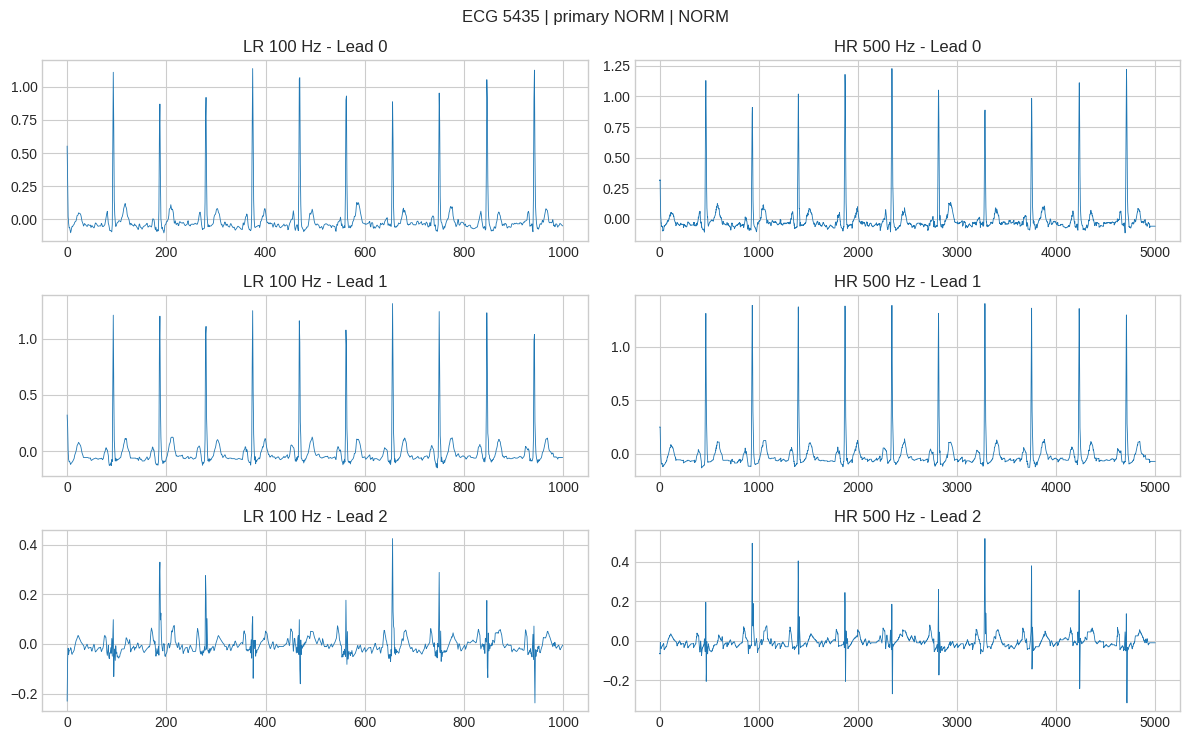

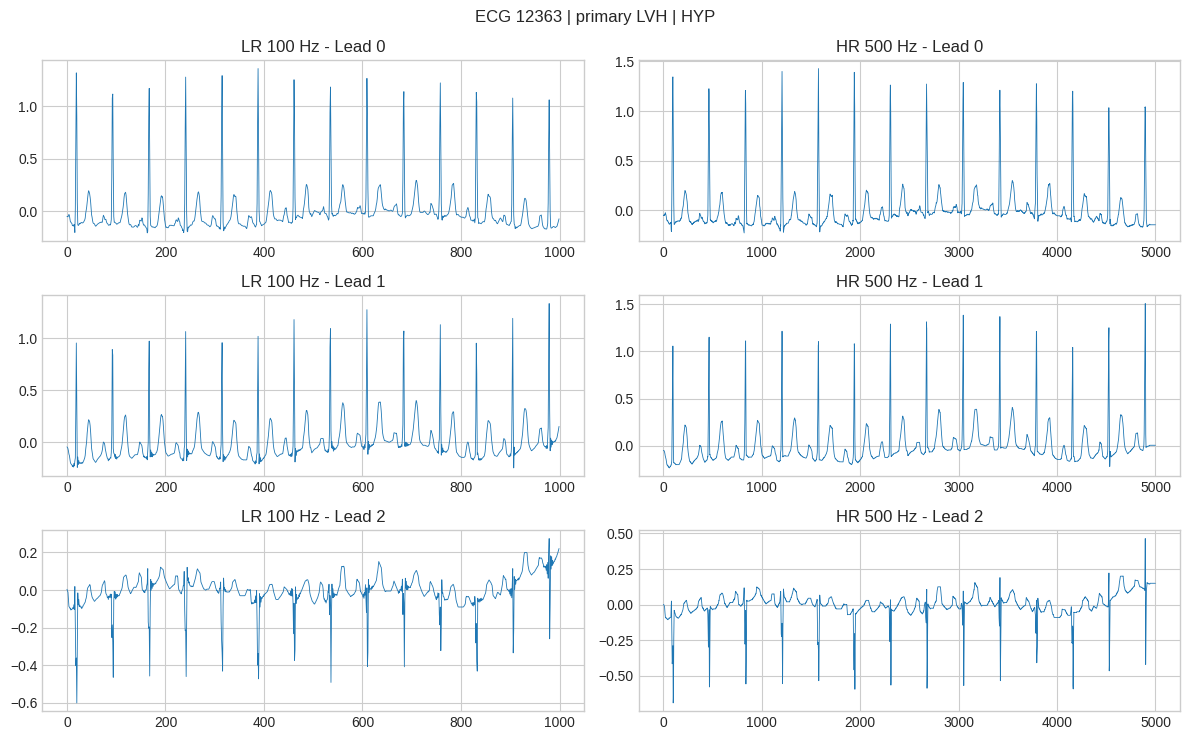

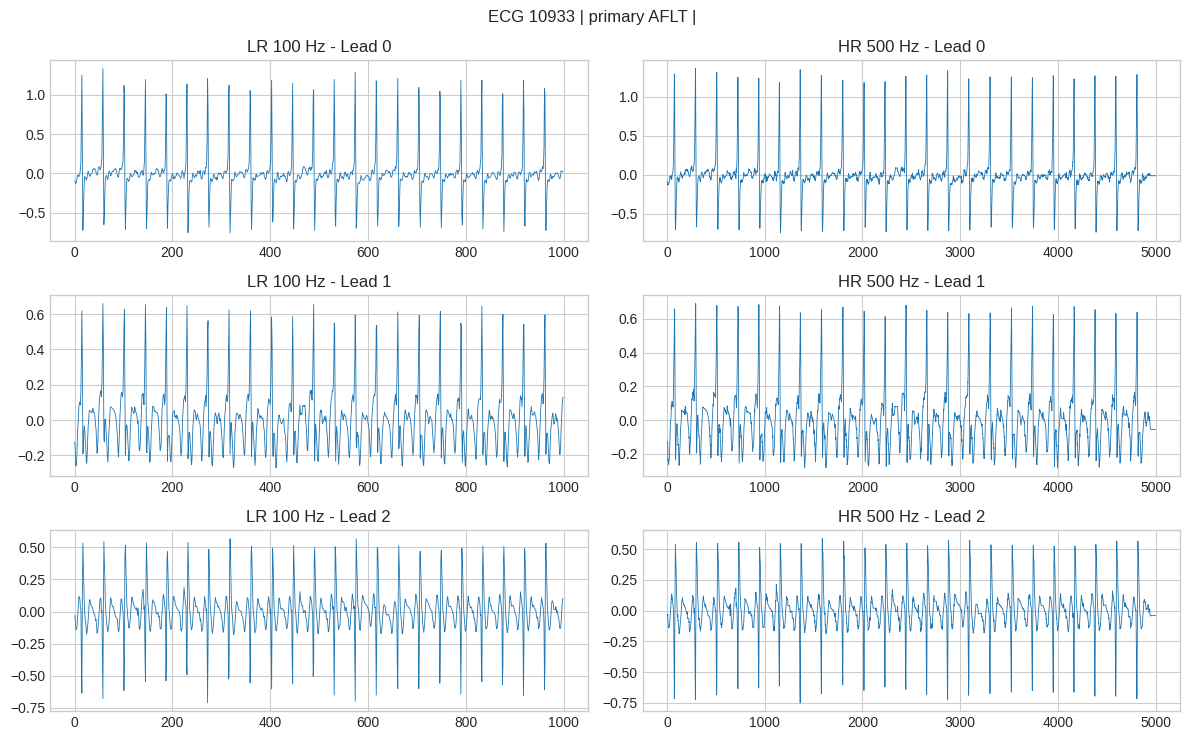

In [7]:
def read_wfdb_safely(path):
    if wfdb is None:
        return None, None
    try:
        signal, meta = wfdb.rdsamp(path)
        return signal, meta
    except Exception as e:
        warnings.warn(f"Failed to read {path}: {e}")
        return None, None

# Pick a few sample rows that have both lr and hr
sample_idxs = ptbxl_df.sample(n=min(3, len(ptbxl_df)), random_state=0).index.tolist()
for idx in sample_idxs:
    row = ptbxl_df.loc[idx]
    lr_path = os.path.join(DATA_ROOT, row.get('filename_lr', ''))
    hr_path = os.path.join(DATA_ROOT, row.get('filename_hr', ''))
    sig_lr, meta_lr = read_wfdb_safely(lr_path)
    sig_hr, meta_hr = read_wfdb_safely(hr_path)
    if sig_lr is None or sig_hr is None:
        print(f"Skipping index {idx} due to missing signals or wfdb.")
        continue

    n_plot = min(3, sig_lr.shape[1])
    t_lr = np.arange(sig_lr.shape[0])
    t_hr = np.arange(sig_hr.shape[0])

    fig, axes = plt.subplots(n_plot, 2, figsize=(12, 2.5*n_plot), sharex=False)
    for i in range(n_plot):
        axes[i, 0].plot(t_lr, sig_lr[:, i], lw=0.6)
        axes[i, 0].set_title(f'LR 100 Hz - Lead {i}')
        axes[i, 1].plot(t_hr, sig_hr[:, i], lw=0.6)
        axes[i, 1].set_title(f'HR 500 Hz - Lead {i}')
    fig.suptitle(f"ECG {int(row['ecg_id'])} | primary {row['primary_scp']} | {','.join(row['diagnostic_superclass'])}")
    plt.tight_layout(); plt.show()


## 7) Signal quality control and duration

Why this matters:
- Consistent preprocessing choices (z-score, filtering) require understanding amplitude and duration distributions.
- Noise flags help plan augmentation and robustness tests.



/tmp/ipykernel_1214992/310610386.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  noise_df = ptbxl_df[noise_cols].applymap(to_binary)


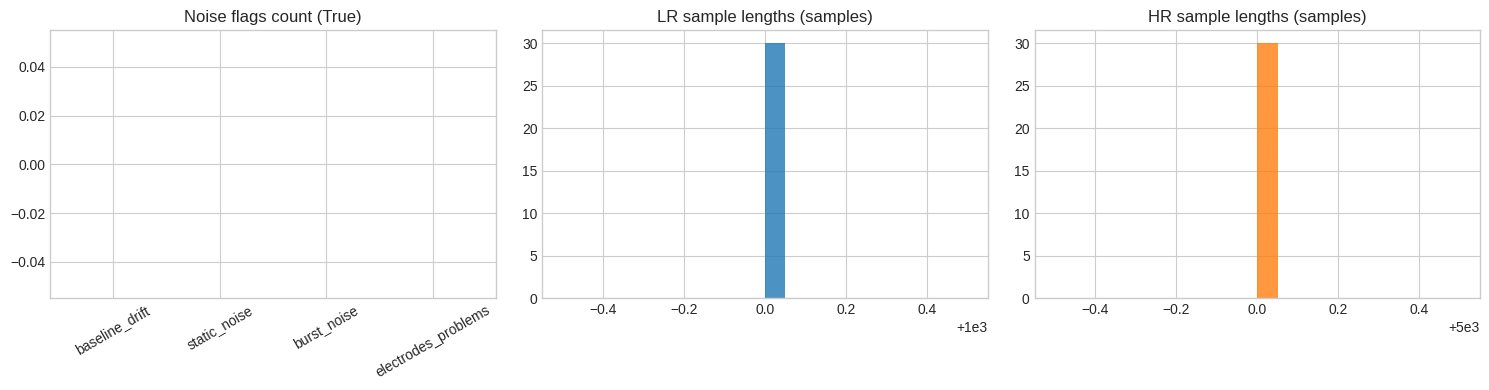

In [8]:
noise_cols = ['baseline_drift','static_noise','burst_noise','electrodes_problems']

# Coerce noise flags to binary
def to_binary(x):
    if pd.isna(x):
        return 0
    if isinstance(x, (bool, np.bool_)):
        return int(x)
    if isinstance(x, (int, np.integer, float, np.floating)):
        return int(x != 0)
    if isinstance(x, str):
        s = x.strip().lower()
        if s in {'1','true','t','yes','y'}:
            return 1
        if s in {'0','false','f','no','n',''}:
            return 0
    return 0

noise_df = ptbxl_df[noise_cols].applymap(to_binary)
noise_counts = noise_df.sum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].bar(range(len(noise_counts)), noise_counts.values, color='tab:gray')
axes[0].set_xticks(range(len(noise_counts)))
axes[0].set_xticklabels(noise_counts.index, rotation=30)
axes[0].set_title('Noise flags count (True)')

# Duration approximation: for LR/HR, infer from filename columns if present
has_lr = ptbxl_df['filename_lr'].notna().sum() > 0
has_hr = ptbxl_df['filename_hr'].notna().sum() > 0

# If wfdb available, sample durations from a subset
sample_for_duration = ptbxl_df.sample(n=min(30, len(ptbxl_df)), random_state=1)
lengths_lr, lengths_hr = [], []
if wfdb is not None:
    for _, row in sample_for_duration.iterrows():
        lr_path = os.path.join(DATA_ROOT, row.get('filename_lr', ''))
        hr_path = os.path.join(DATA_ROOT, row.get('filename_hr', ''))
        sig_lr, _ = (None, None)
        sig_hr, _ = (None, None)
        try:
            if lr_path:
                sig_lr, _ = wfdb.rdsamp(lr_path)
        except Exception:
            pass
        try:
            if hr_path:
                sig_hr, _ = wfdb.rdsamp(hr_path)
        except Exception:
            pass
        if sig_lr is not None:
            lengths_lr.append(sig_lr.shape[0])
        if sig_hr is not None:
            lengths_hr.append(sig_hr.shape[0])

axes[1].hist(lengths_lr, bins=20, color='tab:blue', alpha=0.8)
axes[1].set_title('LR sample lengths (samples)')
axes[2].hist(lengths_hr, bins=20, color='tab:orange', alpha=0.8)
axes[2].set_title('HR sample lengths (samples)')
plt.tight_layout(); plt.show()


## 8) Waveform gallery samples per label

Why this matters:
- Qualitative sanity check for label quality and noise; helpful for stakeholders.
- We sample examples per superclass with safe fallbacks when `wfdb` or files are unavailable.



Superclass CD | ecg_id=16745 | primary_scp=1AVB


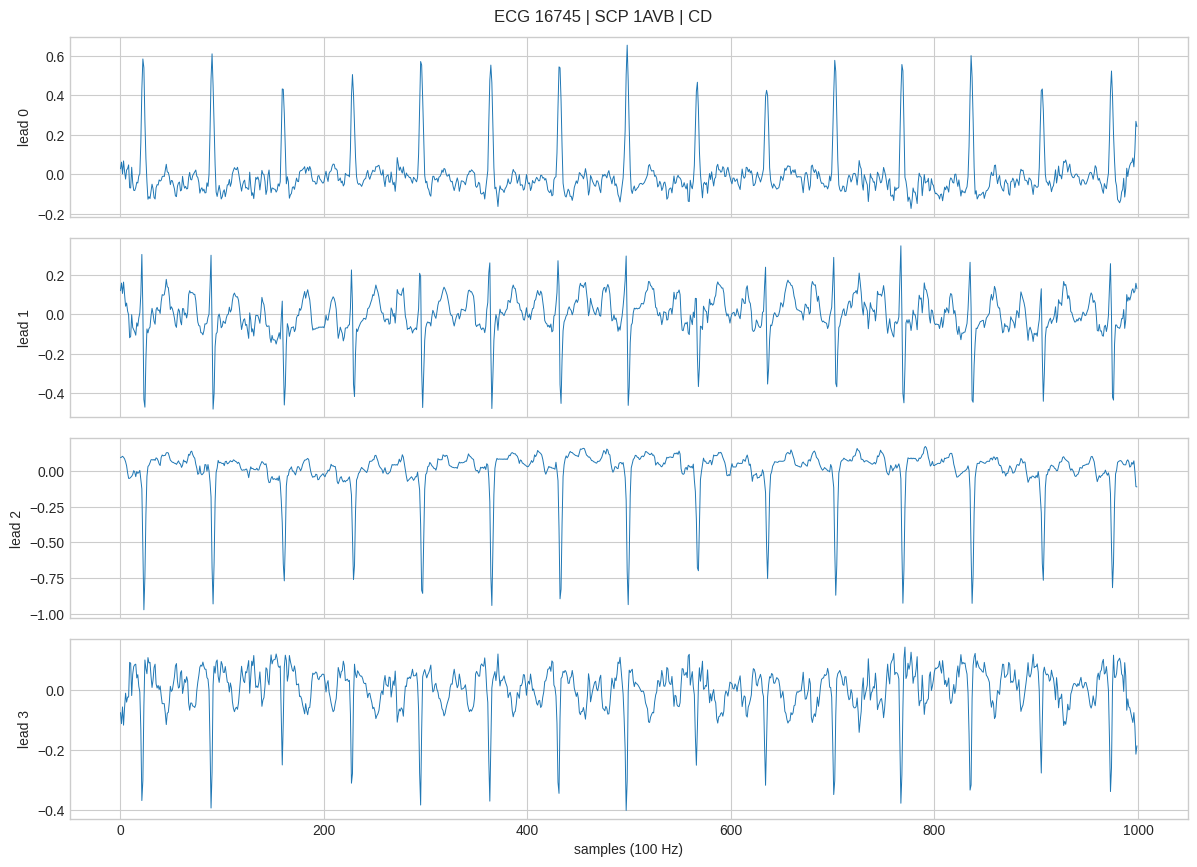

Superclass HYP | ecg_id=5005 | primary_scp=ISC_


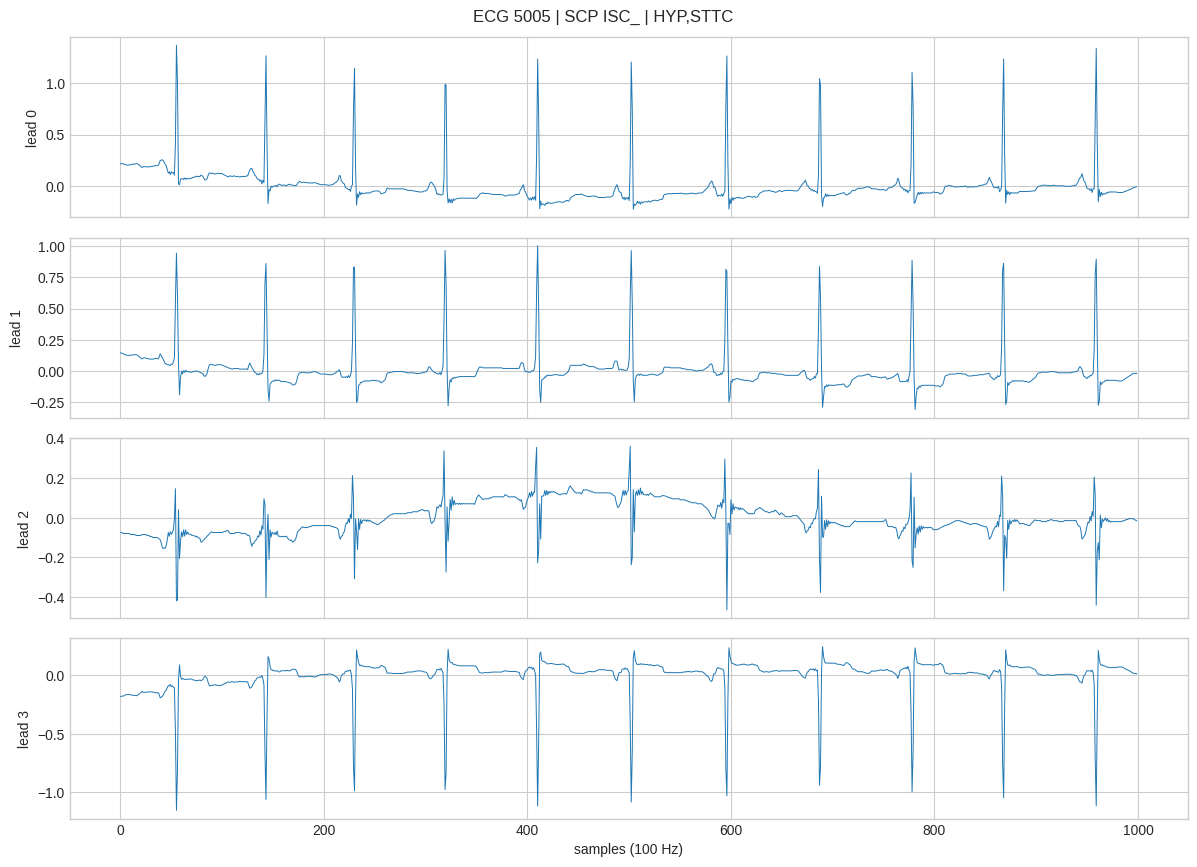

Superclass MI | ecg_id=14318 | primary_scp=IMI


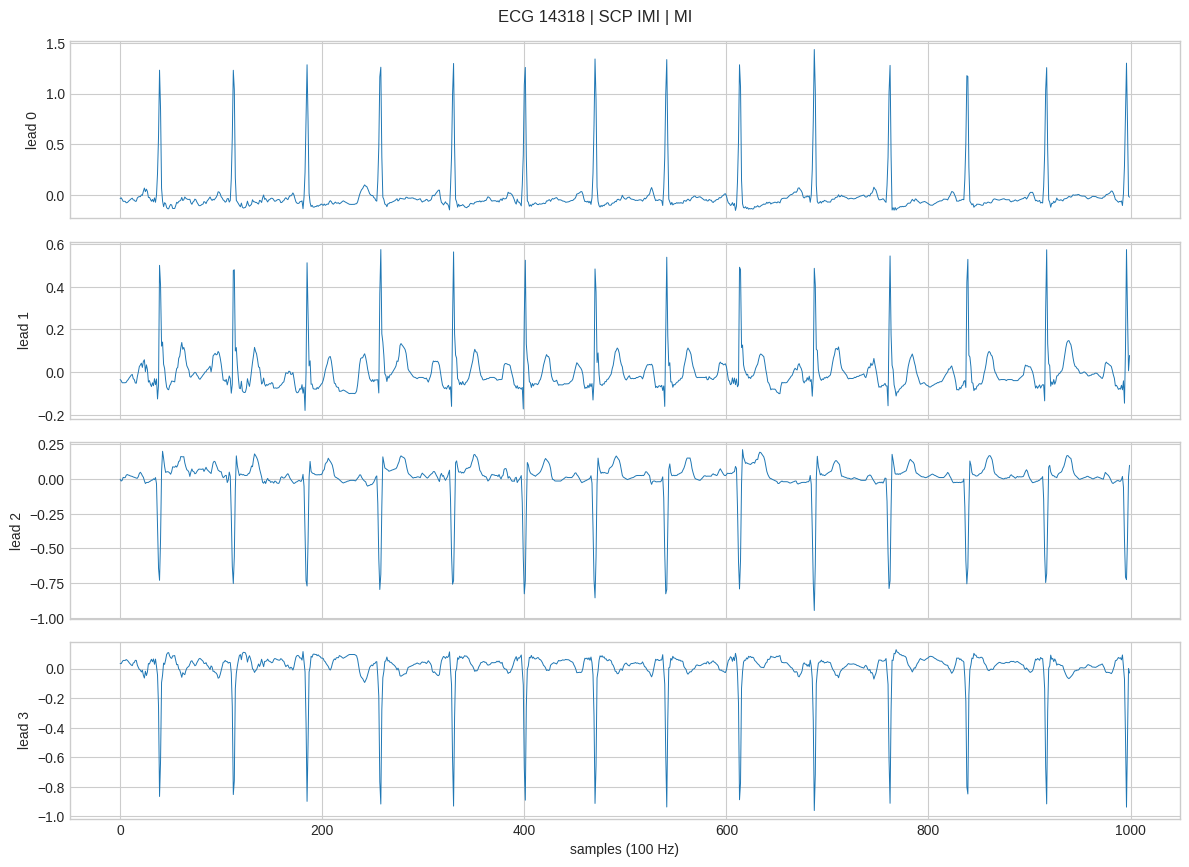

Superclass NORM | ecg_id=5929 | primary_scp=NORM


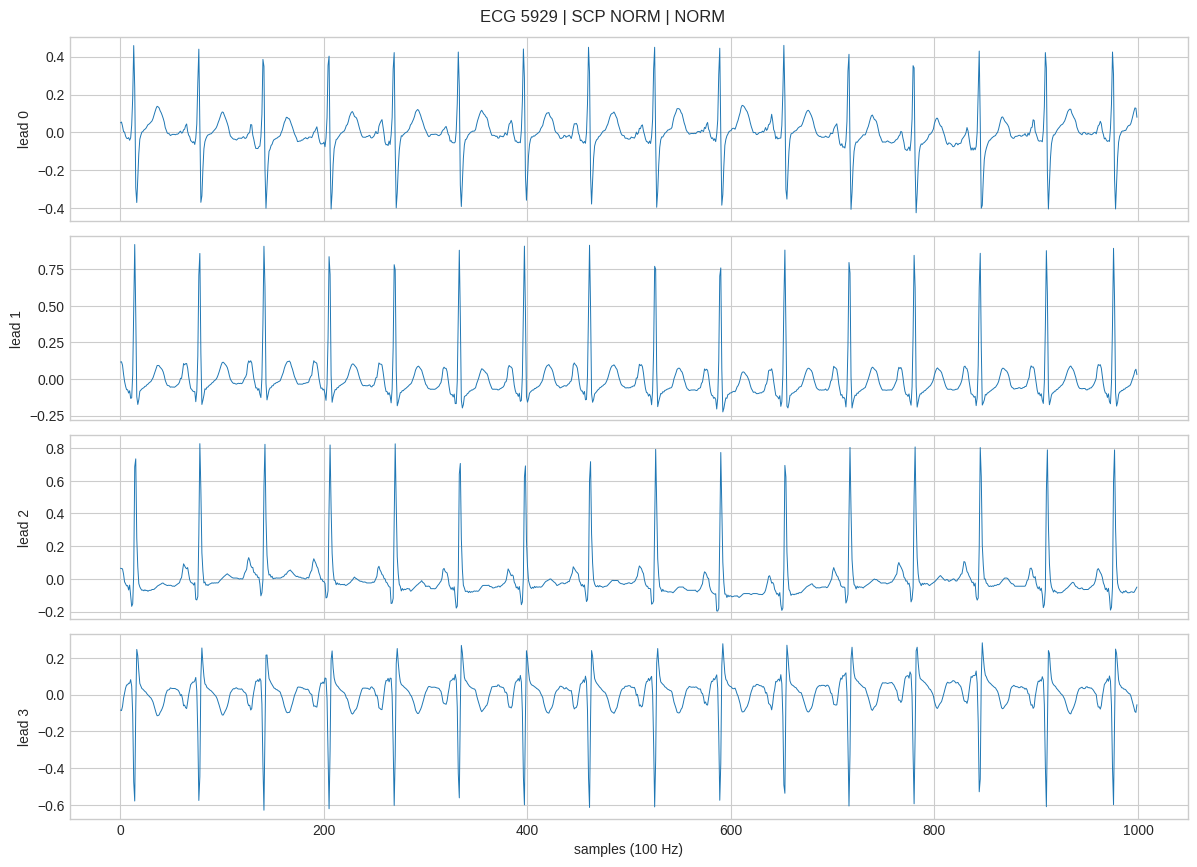

Superclass STTC | ecg_id=7945 | primary_scp=NDT


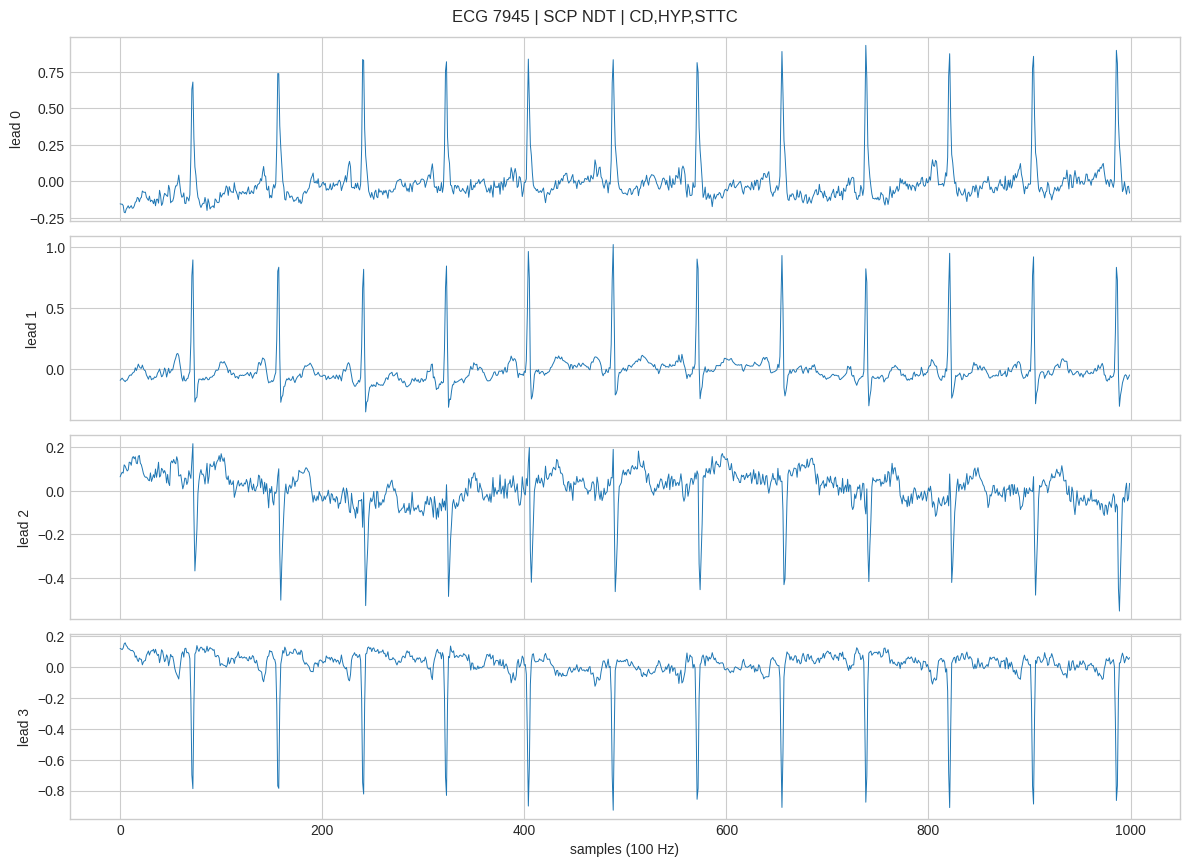

In [9]:
def plot_record_lr(ecg_row, n_leads=4):
    if wfdb is None:
        return False
    lr_path = os.path.join(DATA_ROOT, ecg_row.get('filename_lr', ''))
    try:
        sig, meta = wfdb.rdsamp(lr_path)
    except Exception:
        return False
    n_plot = min(n_leads, sig.shape[1])
    t = np.arange(sig.shape[0])
    fig, axes = plt.subplots(n_plot, 1, figsize=(12, 2.2*n_plot), sharex=True)
    if n_plot == 1:
        axes = [axes]
    for i in range(n_plot):
        axes[i].plot(t, sig[:, i], lw=0.7)
        axes[i].set_ylabel(f'lead {i}')
    axes[-1].set_xlabel('samples (100 Hz)')
    fig.suptitle(f"ECG {int(ecg_row['ecg_id'])} | SCP {ecg_row['primary_scp']} | {','.join(ecg_row['diagnostic_superclass'])}")
    plt.tight_layout(); plt.show()
    return True

# Sample one random record per superclass (if available)
for c in superclasses:
    subset_idx = [i for i, classes in enumerate(ptbxl_df['diagnostic_superclass']) if c in classes]
    if len(subset_idx) == 0:
        continue
    row = ptbxl_df.iloc[np.random.choice(subset_idx)]
    print(f"Superclass {c} | ecg_id={row['ecg_id']} | primary_scp={row['primary_scp']}")
    ok = plot_record_lr(row, n_leads=4)
    if not ok:
        print("  (skipped: waveform not available)")


## 9) Practical recommendations for modeling directions

Why this matters:
- Turns insights into an actionable plan for baselines, ablations, and future work.

Key takeaways:
- Use patient-wise splits (official folds satisfy this); confirm no leakage (we did).
- Start with 12-lead, 100 Hz, per-record z-score; add bandpass (0.5–40 Hz) and notch if needed.
- Targets: multi-label superclasses + optionally frequent SCPs; consider multi-task with rhythm/form.
- Handle imbalance with weighted BCE or focal loss; tune thresholds per label on validation.
- Evaluate AUROC/AP per label (macro/micro) and by groups (sex, age, device, site).
- Probe robustness: lead dropout, domain shift across devices/sites, noise augmentations.
- Extensions: self-supervised pretraining and cross-dataset generalization to MIMIC-IV ECG.

